## CS156 LBA Assignment
---
*Core assignment:*

Write code that does the following:

- Processes all photos down to a size not exceeding 512 pixels in either width or height
- Using principal components analysis (PCA) project your images down to a 2 dimensional representation
- Visually inspect the 2D locations of each photo in the new space
- Show the reconstruction from each low-dimensional representation
- Finally, pick a point that is far away from any known location and plot its reconstruction

Make sure to include:

- at least 10 of your small photos and their associated reconstructions
- the scatterplot of all images in the 2D space, and where your new point is
- the reconstruction from your new point

In [230]:
# import all necessary modules
!pip install python-resize-image
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition

### Data Collection and Pre-processing

For this LBA, I decided to take pictures of the Torre Monumental in Buenos Aires, a clock tower commemorating Argentina's independece. This landmark is visible from every apartment in the residence ending in "05" (e.g. my apartment number is 1605 and has a 16th-floor view of the clock tower). Upon realizing that I had access to 11 such apartments spread across floors 16 through 44, each with the same two vertically-aligned windows to take visually consistent pictures from, I decided to explore the variance introduced by height difference between apartments in this assignment. I knocked on the door of every Minerva-occupied "05" room (floors 16, 17, 23, 27, 30, 33, 35, 38, 39, 41, 44) and took two pictures of the clock tower from each apartment, placing my phone on the same corresponding corner of the vertically-aligned windows in each apartment.

It was my hope to get consistent enough pictures that the main source of variation between them were the height difference. The resulting pictures are imported, resized, and converted into an array format in the cell below.

Total Images: 22
Images Shape: (22, 786432)


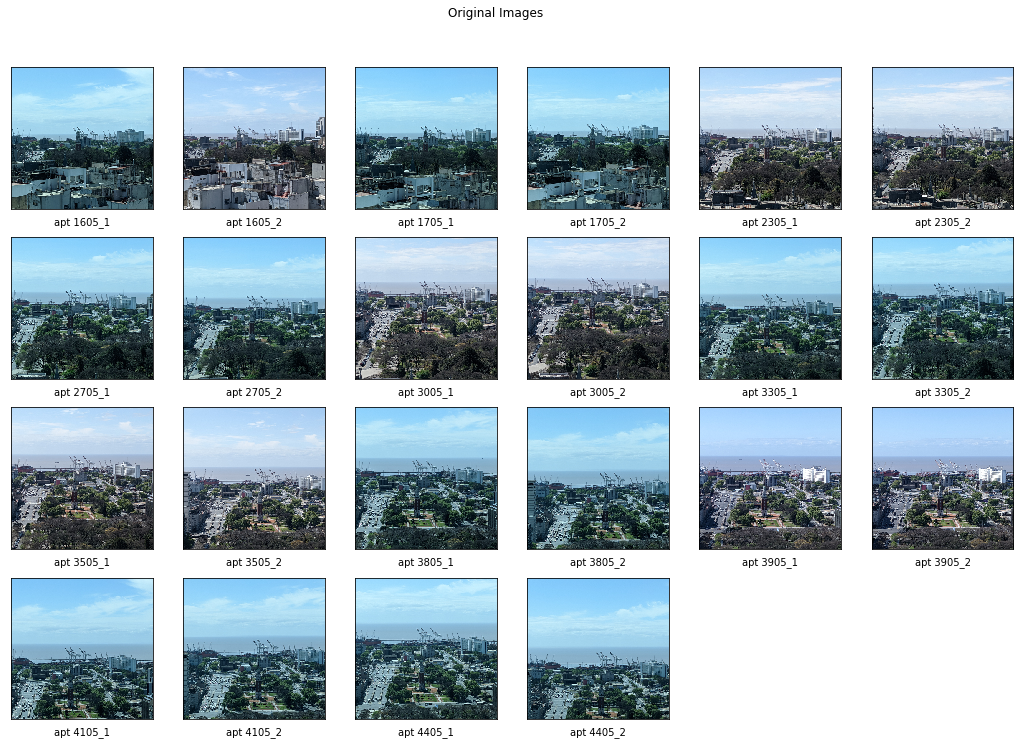

In [232]:
# set the desired pixel size for images
pxsize = 512

# resize and crop images
def resize_images(images):
    '''
    Resizes and crops images using the function given
    in the Session 7 repo from load_images.py.
    '''    

    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, [pxsize,pxsize])
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))


    # Flatten it once more
    flattened = np.asarray(flattened, dtype=object)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    # return resized images
    return X, Y

# resize images using function
files = glob("pictures/*")
images = resize_images(files)[0]

print(f'Total Images: {len(images)}')
print(f'Images Shape: {images.shape}')

# plot samples of original images
fig = plt.figure(figsize=(18, 12))

for i in range(len(images)):
    ax = fig.add_subplot(4, 6, i+1, xticks=[], yticks=[], xlabel=f"apt {files[i][9:15]}")
    img = Image.fromarray(images[i].reshape(pxsize,pxsize,3), 'RGB')
    ax.imshow(img, interpolation='nearest')
    
plt.suptitle('Original Images', y=0.95)
plt.show()

### PCA using 2 components

With the image data flattened into a more mathematically manageable format, we conduct a 2-dimensional principal component analysis on the dataset to determine how much of the variance the first two components capture.

In [257]:
# apply PCA using 2 components
n_components = 2

pca = decomposition.PCA(n_components=n_components)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)
print(transformed.shape)

# find explained variance based on number of components
components = np.arange(1, n_components+1, step=1)
var = np.cumsum(pca.explained_variance_ratio_)

for i in range(0,n_components):
    print(f"{components[i]} PC(s) explain(s) {var[i]*100:.0f}% of variance")

(22, 2)
1 PC(s) explain(s) 18% of variance
2 PC(s) explain(s) 27% of variance


#### Analysis
The first two components (out of 22) only cumulatively capture 27% of the variance in the dataset. This is useful but suggests there are multiple components with significant loadings. In other words, the original dataset varies in several different ways.

### Plotting dataset in 2D PCA plot and introducing an Artificial Datapoint

With the dataset decomposed into a 2-dimensional representation according to its first two principal components, we can represent eahc image as a point on a 2D scatter plot with axes given by each PC, and analyze them accordingly.

Furthermore, given the 2D representation of all images in the dataset, we can fabricate an artificial (fake) datapoint with widely distant values for each PC and plot it alongside the real dataset. This artifical datapoint represents the hypothetical decomposition of an image that would have been considerably different from all those in my real sample.

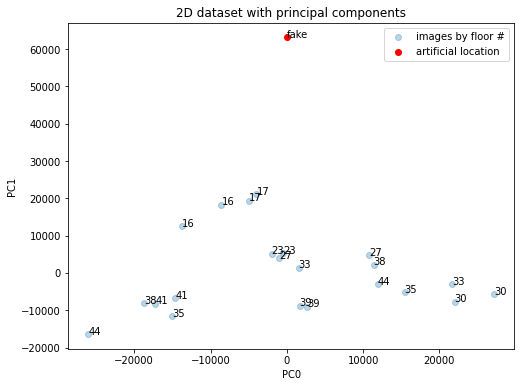

In [259]:
# select two components for plotting datapoints in 2D
PC1_idx = 0
PC2_idx = 1

# fabricate artificial image based on faraway location in 2D PCA plot
fake = np.array([sum(transformed[:,PC1_idx])/2, max(transformed[:,PC2_idx])*3])

# plot images as points in 2D using principal components as axes
plt.figure(figsize=(8,6))
plt.scatter(transformed[:,PC1_idx], transformed[:,PC2_idx], alpha=0.3, label="images by floor #")

for i, txt in enumerate(files):
    plt.annotate(txt[9:11], (transformed[i,PC1_idx], transformed[i,PC2_idx]))

plt.gca().set(
    title="2D dataset with principal components",
    xlabel=f"PC{PC1_idx}",
    ylabel=f"PC{PC2_idx}",
)

# plot fake image in 2D PCA plot
plt.scatter(fake[0], fake[1], color='red', label="artificial location")
plt.annotate('fake', (fake[0], fake[1]))


plt.legend()
plt.show()

#### Analysis

The scatter plot shows the images as they vary across the first two principal components, we can identify clusters of certain picture groups corresponding to floors at similar heights, like floors 16 and 17, 23 and 27, or 30 and 33, this suggests some of the features shared by these pictures, taken closer apart than others, are contained in the 2 principal components found with PCA.

I chose to fabricate the artificial datapoint faraway from the real dataset, but specifically far away in the same direction that the four images from floors 16 and 17 clearly cluster away from the rest of the images (i.e. higher `PC1` values), this should represent a fake reconstructed image that differs greatly from most of the real ones, but less so from the pictures taken from the two lower floors (16th and 17th).

### Reconstructing Fake Image from Artificial Datapoint

With the aritificial datapoint generated in the previous step, we can produce a fake image, usign the inverse transformation to that which yielded the 2D representation of the original picture dataset. We found that the first two components only capture 27% of the variance in the original dataset, so we can expect a reconstructed fake image that displays an approximate 27% of similitude with the pictures in the dataset. Since I chose aritificial values faraway in the direction of the 16th and 17th floor cluster, we expect the fake image to most closely resemble these images out of all in the dataset.

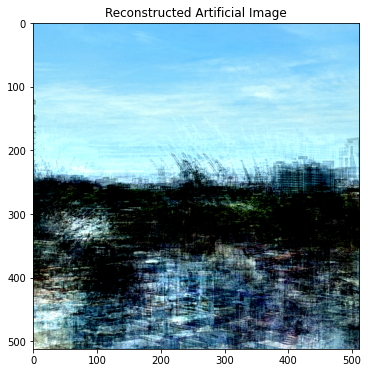

In [260]:
# reconstruct image based on artifical faraway location

# transform image to save reconstruction
inverse = pca.inverse_transform(fake)
formatted = np.clip(inverse, 0, 255).astype(np.uint8)

# calculate explained variance
pca_var_expl = \
np.round(np.cumsum(pca.explained_variance_ratio_)[-1],2)

# reshape
reshaped = Image.fromarray(formatted.reshape(pxsize,pxsize,3), 'RGB')

# plot reconstruction from fake image
plt.figure(figsize=(8,6))
plt.imshow(reshaped)
plt.title(f'Reconstructed Artificial Image')
plt.show()


#### Analysis

Indeed we find that the reconstructed artificial image includes a blocky, greyish white bottom section, mainly present in the pictures taken from the 16th and 17th floor.

### PCA using all components

We can conduct a principal component analysis using all components, which should cumulatively explain 100% of the variance in the dataset, in order to find the cumulative variance explained by each subsequently added component. Replotting low-dimensional scatter plots like the one above using a full-component decomposition could provide valuable insight by allowing us to plot the data along the axes of small sets of PCs, choosing specific ones to compare between.

(22, 22)


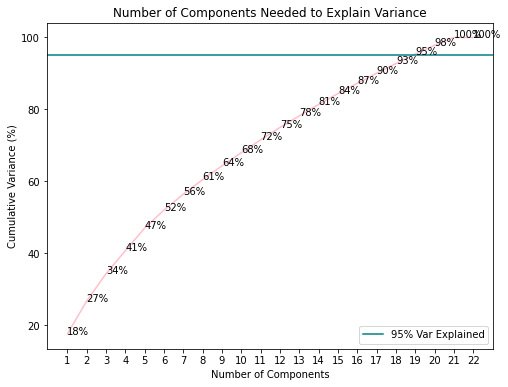

In [261]:
# apply PCA using all components
n_components = len(images)

pca = decomposition.PCA(n_components=n_components)

# fit images to PCA to reduce dimensions
transformed = pca.fit_transform(images)
print(transformed.shape)

# plot number of components vs. explained variance
plt.figure(figsize=(8,6))

components = np.arange(1, n_components+1, step=1)
var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, var*100, color='pink')
plt.xticks(np.arange(min(components), max(components)+1, 1))
plt.axhline(y=95, color='teal', label='95% Var Explained')

for i, txt in enumerate(var):
    plt.annotate(f'{txt*100:.0f}%', (components[i], var[i]*100))
    
plt.title('Number of Components Needed to Explain Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.legend(loc=4)
plt.show()

#### Analysis

We can see from the figure above that most of the principal components are necessary in order to capture a high percentage of the variance in the picture dataset. This supports the idea that the images in the original dataset differ considerably from one another and along multiple features, if there were few isolated sources of visual differentiation between them, we would expect to capture their corresponding variance with similarly fewer principal components. After running this analysis multiple times with different inputs, I noticed that processing the pictures atlower resolutions results in more variance captured by the first few PCs, which was an interesting way of realizing the data loss inherent to lowering the resolution of an image.

### Reconstructing samples from the original dataset

We can reconstruct any of the original images using any number of PCs, if we decompose them to that number of dimensions first. Below, I do this and visualize the results of a random image sample drawn for each incremental component, alongside the variance explained by the components selected for that reconstruction. It is interesting to notice certain images yielded higher-quality reconstructions even at lower dimensions (e.g. `apt 3005_2` at 8 dimensions), this suggests the first 8 dimensions contain most of the variance relevant to that sepcific picture.

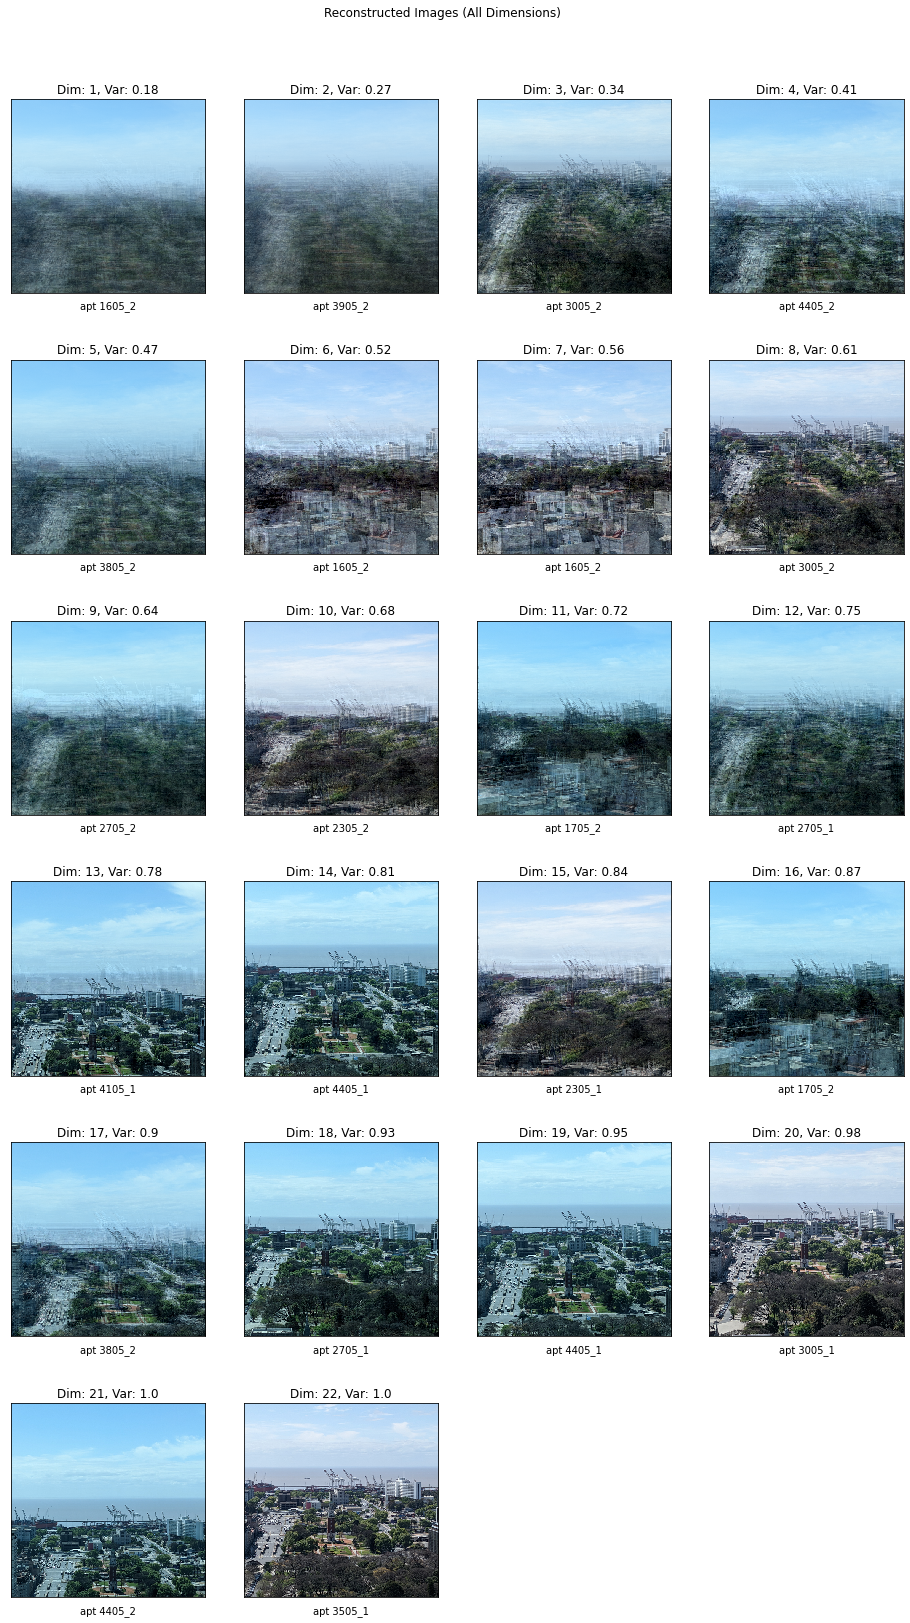

In [207]:
# calculate PCA results and save image for each dimension

tags = []
samples = []
expl_var = []
dims = []

for i in range(1,len(images)+1,1):
    
    # apply PCA
    pca = decomposition.PCA(n_components=i)

    # fit images to PCA to reduce dimensions
    transformed = pca.fit_transform(images)
    
    # transform image to save samples
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)
    
    # save one random sample from each dimension
    random_row = np.random.randint(len(images), size=1)
    sample = formatted[random_row]
    tag = files[random_row[0]]
    
    # calculate explained variance
    pca_var_expl = \
    np.round(np.cumsum(pca.explained_variance_ratio_)[-1],2)
    
    # save results
    tags.append(tag)
    samples.append(sample)
    expl_var.append(pca_var_expl)
    dims.append(i)
    

# reshape formatted samples
reshaped = []
for i in samples:
    new_img = Image.fromarray(i.reshape(pxsize,pxsize,3), 'RGB')
    reshaped.append(new_img)

# plot samples
fig = plt.figure(figsize=(16, 28))

for i in range(len(samples)): 
    ax = fig.add_subplot(6, 4, i+1, xticks=[], yticks=[], xlabel=f"apt {tags[i][9:15]}") 
    ax.imshow(reshaped[i], interpolation='nearest')
    ax.set_title(f'Dim: {dims[i]}, Var: {expl_var[i]}')
    
plt.suptitle('Reconstructed Images (All Dimensions)', y=0.92)

plt.show()